In [1]:
# Install necessary libraries for training
!pip install torch torchvision optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
# Import necessary dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import optuna
from PIL import Image
import matplotlib.pyplot as plt

Load the Dataset

In [3]:
# Define file paths for training and testing images and labels
train_imgs_path = '/dataset/k49-train-imgs.npz'
train_labels_path = '/dataset/k49-train-labels.npz'
test_imgs_path = '/dataset/k49-test-imgs.npz'
test_labels_path = '/dataset/k49-test-labels.npz'

# Load data
train_images = np.load(train_imgs_path)['arr_0']
train_labels = np.load(train_labels_path)['arr_0']
test_images = np.load(test_imgs_path)['arr_0']
test_labels = np.load(test_labels_path)['arr_0']

# Check the loaded data
print("Shape of train images:", train_images.shape)
print("Shape of train labels:", train_labels.shape)
print("Shape of test images:", test_images.shape)
print("Shape of test labels:", test_labels.shape)

Shape of train images: (232365, 28, 28)
Shape of train labels: (232365,)
Shape of test images: (38547, 28, 28)
Shape of test labels: (38547,)


Display Some Images from the Dataset

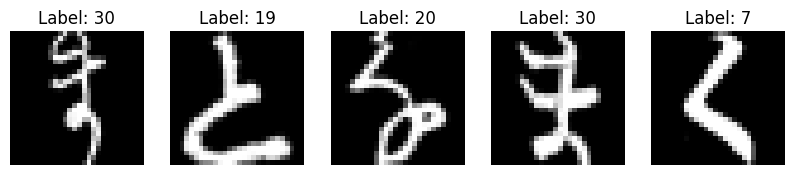

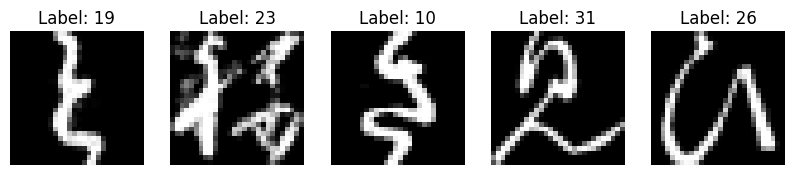

In [4]:
# Show some images
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

show_images(train_images, train_labels, num_images=5)
show_images(test_images, test_labels, num_images=5)

Format the Dataset for Deep Learning and Apply Data Augmentation

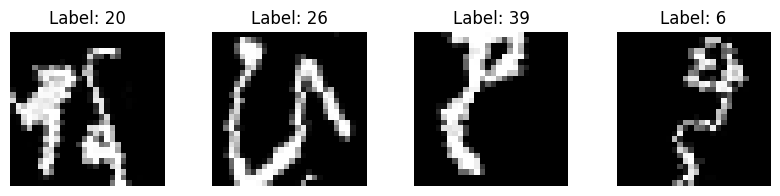

In [17]:
class HiraganaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # Initialize dataset with images, labels, and optional transformations
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Return the total number of images
        return len(self.images)

    def __getitem__(self, idx):
        # Retrieve image and label at the specified index
        image = self.images[idx]
        image = Image.fromarray(image)  # Convert numpy array to PIL image
        label = self.labels[idx]

        # Apply transformations if any are specified
        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformations for training
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate images by up to 30 degrees
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random affine transformations
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5], [0.5])  # Normalize with mean and std deviation of 0.5
])

# Define data transformations for validation
val_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5], [0.5])  # Normalize with mean and std deviation of 0.5
])

# Prepare datasets and dataloaders for training and validation
train_dataset = HiraganaDataset(train_images, train_labels, transform=train_transforms)
val_dataset = HiraganaDataset(test_images, test_labels, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

def show_augmented_images(data_loader, num_images=4):
    # Display a sample of augmented images from the dataloader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        image = images[i].squeeze(0)  # Remove channel dimension
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

show_augmented_images(train_loader, num_images=4)

Define the SpinalVGG Model to Use for Training

In [6]:
# Define two hyperparameters for the fully connected layers in the SpinalVGG model
Half_width = 128  # Width of each half of the input for spinal layers
layer_width = 128  # Output width (number of neurons) in each spinal fully connected layer

# Define the model architecture to be used in training
class SpinalVGG(nn.Module):
    def two_conv_pool(self, in_channels, f1, f2):
        # Define a layer block with two convolution layers, batch normalization, and max pooling
        return nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def three_conv_pool(self, in_channels, f1, f2, f3):
        # Define a layer block with three convolution layers, batch normalization, and max pooling
        return nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def __init__(self, num_classes=49):
        super(SpinalVGG, self).__init__()
        # Define sequential blocks using the two- and three-layer blocks
        self.l1 = self.two_conv_pool(1, 64, 64)
        self.l2 = self.two_conv_pool(64, 128, 128)
        self.l3 = self.three_conv_pool(128, 256, 256, 256)
        self.l4 = self.three_conv_pool(256, 256, 256, 256)

        # Define the Spinal fully connected layers with dropout and batch normalization
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(Half_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True))
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True))
        
        # Define the final output layer
        self.fc_out = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(layer_width * 4, num_classes))

    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers

        # Forward pass through Spinal fully connected layers
        x1 = self.fc_spinal_layer1(x[:, 0:Half_width])
        x2 = self.fc_spinal_layer2(torch.cat([x[:, Half_width:2*Half_width], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:Half_width], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([x[:, Half_width:2*Half_width], x3], dim=1))

        # Concatenate outputs and pass through final layer
        x = torch.cat([x1, x2, x3, x4], dim=1)
        x = self.fc_out(x)
        return F.log_softmax(x, dim=1)  # Apply log softmax to output
    

Conduct a Brief Tuning with Optuna to Find the Optimal Hyperparameters

In [7]:
def objective(trial):
    device = torch.device("cuda")
    model = SpinalVGG(num_classes=49).to(device)

    # Hyperparameter optimization
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])  # Suggest an optimizer type
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)  # Suggest a learning rate
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    num_epochs = 25  # Use fewer epochs for initial tuning

    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Calculate accuracy on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        epoch_acc = correct / total
        scheduler.step(epoch_acc)  # Update learning rate scheduler

        # Update the best accuracy if the current epoch accuracy is higher
        if epoch_acc > best_acc:
            best_acc = epoch_acc

    return best_acc  # Return accuracy for Optuna to maximize

# Use Optuna to find the best hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Output the best parameters
best_lr = study.best_trial.params["lr"]
best_optimizer_name = study.best_trial.params["optimizer"]
print("Best params:", study.best_trial.params)


[I 2024-11-08 17:08:20,827] A new study created in memory with name: no-name-24a425e4-d1eb-48ae-9c50-d05c9d1a5a46
[I 2024-11-08 17:16:27,186] Trial 0 finished with value: 0.9205645056684048 and parameters: {'optimizer': 'AdamW', 'lr': 5.4847794731137024e-05}. Best is trial 0 with value: 0.9205645056684048.
[I 2024-11-08 17:24:37,093] Trial 1 finished with value: 0.24237943290009598 and parameters: {'optimizer': 'SGD', 'lr': 0.000883054502994028}. Best is trial 0 with value: 0.9205645056684048.
[I 2024-11-08 17:32:39,715] Trial 2 finished with value: 0.8992917736788855 and parameters: {'optimizer': 'AdamW', 'lr': 4.1846757228227996e-05}. Best is trial 0 with value: 0.9205645056684048.
[I 2024-11-08 17:40:47,050] Trial 3 finished with value: 0.6540846239655486 and parameters: {'optimizer': 'AdamW', 'lr': 1.2036881687783096e-05}. Best is trial 0 with value: 0.9205645056684048.
[I 2024-11-08 17:48:58,685] Trial 4 finished with value: 0.8702622772200171 and parameters: {'optimizer': 'AdamW'

Best params: {'optimizer': 'Adam', 'lr': 0.0008054639911113817}


Starting Formal Training with the Best Hyperparameters Obtained from Optuna

In [18]:
def train_with_best_params(best_lr, best_optimizer_name, num_epochs=200, patience=10):
    device = torch.device("cuda")
    model = SpinalVGG(num_classes=49).to(device)
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimizer = getattr(optim, best_optimizer_name)(model.parameters(), lr=best_lr)  # Initialize optimizer with best parameters
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    best_acc = 0.0  # Track the best accuracy
    epochs_no_improve = 0  # Track epochs without improvement for early stopping
    best_model_wts = model.state_dict()  # Store the best model weights

    # Initialize lists to record training loss and validation accuracy for each epoch
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0  # Accumulate loss for the epoch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)  # Accumulate batch loss

        epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        epoch_acc = correct / total  # Calculate validation accuracy
        val_accuracies.append(epoch_acc)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.4f}')

        # Get current learning rate
        current_lr = scheduler.get_last_lr()[0]

        # Step the learning rate scheduler based on validation accuracy
        scheduler.step(epoch_acc)

        # Check if learning rate has decayed
        new_lr = scheduler.get_last_lr()[0]
        if new_lr < current_lr:
            print(f"Learning rate decayed to: {new_lr}")

        # Early stopping: check if validation accuracy improved
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()  # Update best weights
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

    # Load the best model weights before returning the model
    model.load_state_dict(best_model_wts)

    # Save the best model to disk
    torch.save(model.state_dict(), "best_spinalvgg_model.pth")
    print("Model saved as best_spinalvgg_model.pth")

    return model, train_losses, val_accuracies  # Return the trained model, training losses, and validation accuracies

# Train with the best parameters obtained from hyperparameter optimization
best_model, train_losses, val_accuracies = train_with_best_params(best_lr, best_optimizer_name)


Epoch 1/200, Loss: 0.9834, Val Accuracy: 0.8697
Epoch 2/200, Loss: 0.3701, Val Accuracy: 0.9182
Epoch 3/200, Loss: 0.2882, Val Accuracy: 0.9287
Epoch 4/200, Loss: 0.2430, Val Accuracy: 0.9419
Epoch 5/200, Loss: 0.2147, Val Accuracy: 0.9473
Epoch 6/200, Loss: 0.1951, Val Accuracy: 0.9495
Epoch 7/200, Loss: 0.1780, Val Accuracy: 0.9559
Epoch 8/200, Loss: 0.1665, Val Accuracy: 0.9585
Epoch 9/200, Loss: 0.1536, Val Accuracy: 0.9590
Epoch 10/200, Loss: 0.1469, Val Accuracy: 0.9598
Epoch 11/200, Loss: 0.1373, Val Accuracy: 0.9632
Epoch 12/200, Loss: 0.1330, Val Accuracy: 0.9658
Epoch 13/200, Loss: 0.1251, Val Accuracy: 0.9641
Epoch 14/200, Loss: 0.1210, Val Accuracy: 0.9655
Epoch 15/200, Loss: 0.1158, Val Accuracy: 0.9669
Epoch 16/200, Loss: 0.1117, Val Accuracy: 0.9666
Epoch 17/200, Loss: 0.1088, Val Accuracy: 0.9676
Epoch 18/200, Loss: 0.1041, Val Accuracy: 0.9688
Epoch 19/200, Loss: 0.1016, Val Accuracy: 0.9678
Epoch 20/200, Loss: 0.0999, Val Accuracy: 0.9711
Epoch 21/200, Loss: 0.0975, V

Plotting Images to Check Model Convergence and Results

Training curves saved as training_curves.png


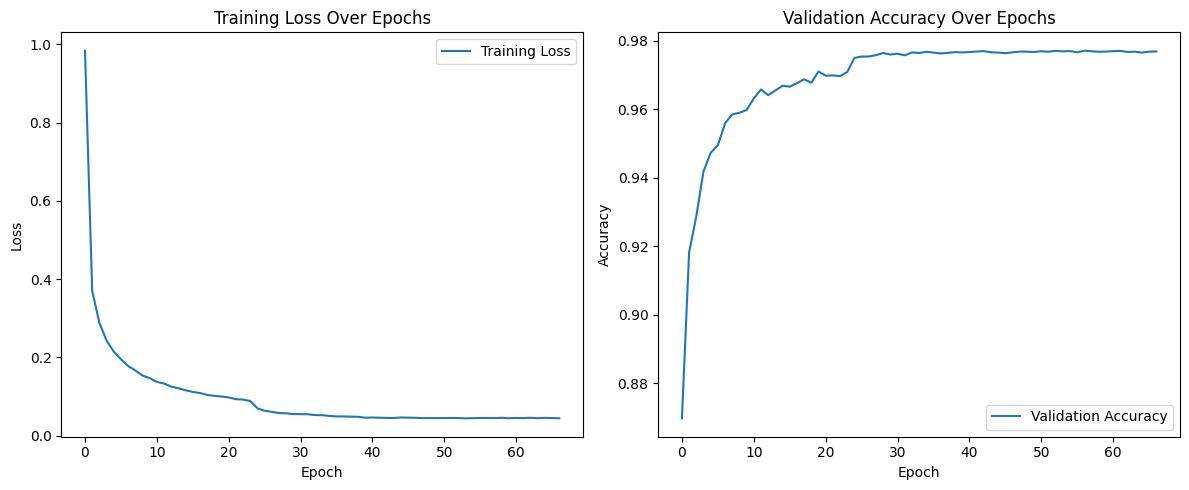

In [19]:
# Plot and save training loss and validation accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Validation accuracy curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("training_curves.png")  # Save the plot as an image file
print("Training curves saved as training_curves.png")

# Display the plot
plt.show()


Using the Recommended Balanced Accuracy to Evaluate Model Performance on the Official Dataset

In [20]:
# Load the saved model
device = torch.device("cuda")
model = SpinalVGG(num_classes=49).to(device)
model.load_state_dict(torch.load("best_spinalvgg_model.pth", weights_only=True))  # Load model weights
model.eval()  # Switch to evaluation mode

# Define a function to calculate Balanced Accuracy
def calculate_balanced_accuracy(model, val_loader):
    y_true = []
    y_pred = []

    # Predict the validation set in batches
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate accuracy for each class
    accs = []
    for cls in range(49):
        mask = (y_true == cls)
        if mask.sum() == 0:
            accs.append(0)  # Handle classes with no samples
        else:
            cls_acc = (y_pred[mask] == cls).mean()  # Accuracy for this class
            accs.append(cls_acc)

    balanced_accuracy = np.mean(accs)  # Mean accuracy across classes (Balanced Accuracy)
    return balanced_accuracy

# Evaluate the model's Balanced Accuracy on the validation set
balanced_accuracy = calculate_balanced_accuracy(model, val_loader)
print(f"Balanced Accuracy on validation set: {balanced_accuracy:.4f}")


Balanced Accuracy on validation set: 0.9726
